# Мэтчинг

## Описание проекта

Заказчику необходимо внедрить систему поиска товаров по запросу пользователя.

Имеются наборы данных уже преобразованных в эмбединги:
- База данных объектов (3 млн строк) - векторы размерностью 72
- Тренировочная выборка (100к строк) - векторы, имеющие лейблы (совпадающие товары из базы выше)
- Тестовая выборка, которая почему-то названа валидационной (100к строк) - векторы для проверки работы алгоритма

### Цель проекта

Найти алгоритм, который находит наиболее удачные совпадения из существующей базы.

Метрикой выбрана accuracy@5, то есть алгоритм отработал удачно, если из 5 результатов предоставлен релевантный.

Искать решение будем в 2 этапа:
- Посмотрим на результаты разных алгоритмов FAISS и выберем наиболее подходящий
- Выберем ранжирующий классификатор, который будет отбирать из n результатов выдачи 5 наиболее подходящих.

## Решение

### Импорт

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance as dist

import faiss

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

import time
import json
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)

### Блок функций

In [2]:
def accuracy_n(target_df, idxs):
    '''
    принимает на вход таргеты и индексы
    возвращает метрику accuracy@n,
    где n - число соседей
    '''
    acc = 0
    for target, el in zip(target_df.values.tolist(), idxs.tolist()):
        acc += int(target in [base_index[r] for r in el])

    return(100 * acc / len(idxs))

def get_distances(vec_1, vec_2):
    '''
    принимает на вход 2 вектора, возвращает список расстояний
    '''
    distances = [
        dist.braycurtis(vec_1,vec_2),
        dist.canberra(vec_1,vec_2),
        dist.chebyshev(vec_1,vec_2),
        dist.cityblock(vec_1,vec_2), #Manhattan
        dist.correlation(vec_1,vec_2),
        dist.cosine(vec_1,vec_2),
        dist.euclidean(vec_1,vec_2),
        dist.minkowski(vec_1,vec_2,3),
        dist.minkowski(vec_1,vec_2,5)
    ]
    return distances

def make_features(candidates, query):
    '''
    принимает на вход:
    candidates - список индексов из base
    query - запрос (изначальный вектор)
    
    возвращает: список расстояний между изначальным запросом
    и каждым кандидатом
    '''
    distances = []
    vec_1 = query
    for candidate in candidates:
        vec_2 = base_array[candidate]
        distances.append(get_distances(vec_1,vec_2))
    return np.array(distances)

def most_similar_5(arr):
    '''сортирует массив, полученный 
    из predict_proba и возвращает
    5 наиболее близких к 1
    '''
    return arr[:,0].argsort()[:5]

def make_concatenated(candidates, query, base):
    '''
    принимает на вход:
    candidates - список индексов из base
    query - запрос (изначальный вектор)
    base - массив для построения индекса
    
    возвращает: попарно сконкатенированные векторы
                из запроса с векторами кандидатов
    '''
    concatenated_vec = []
    vec_1 = query
    for candidate in candidates:
        vec_2 = base[candidate]
        concatenated_vec.append(np.concatenate([vec_1,vec_2]))
    return np.array(concatenated_vec)

### Загрузка и осмотр данных

In [3]:
base_df = pd.read_csv('datasets/base.csv',index_col=0)
display(base_df.head())
print(base_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


(2918139, 72)


In [4]:
train_df = pd.read_csv('datasets/train.csv',index_col=0)
display(train_df.head())
print(train_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


(100000, 73)


In [5]:
validation_df = pd.read_csv('datasets/validation.csv',index_col=0)
display(validation_df.head())
print(validation_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


(100000, 72)


In [6]:
validation_answer_df = pd.read_csv('datasets/validation_answer.csv',index_col=0)
display(validation_answer_df.head())
print(validation_answer_df.shape)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


(100000, 1)


### EDA

Датасеты довольно объемные, признаков довольно много, поэтому полноценный EDA сделать проблематично.

Тем не менее, мы можем оценить:
- распределения признаков
- пропущенные значения
- дубликаты

#### Проверка на дубликаты

In [7]:
print('Дубликатов в base:', base_df.duplicated().sum())
print('Дубликатов в train:', train_df.duplicated().sum())
print('Дубликатов в validation:', validation_df.duplicated().sum())
print('Дубликатов в validation_answer:', validation_answer_df.duplicated().sum())

Дубликатов в base: 0
Дубликатов в train: 0
Дубликатов в validation: 0
Дубликатов в validation_answer: 8498


Есть дубликаты в ответах валидационного датафрейма. То есть некоторые векторы val_df имеют один и тот же ответ из base_df.
Пока не будем ничего с этим делать

#### Проверка на пропущенные значения

In [8]:
train_df.isna().sum().sum()

0

In [9]:
print('Пропущенных значений в base:', base_df.isna().sum().sum())
print('Пропущенных значений в train:', train_df.isna().sum().sum())
print('Пропущенных значений в validation:', validation_df.isna().sum().sum())
print('Пропущенных значений в validation_answer:', validation_answer_df.isna().sum().sum())

Пропущенных значений в base: 0
Пропущенных значений в train: 0
Пропущенных значений в validation: 0
Пропущенных значений в validation_answer: 0


Пропусков нет

#### Проверка распределений

Оценим визуально распределения в base_df. Чтобы не просчитывать 3 млн строк, сделаем это на основе выборки в 5%

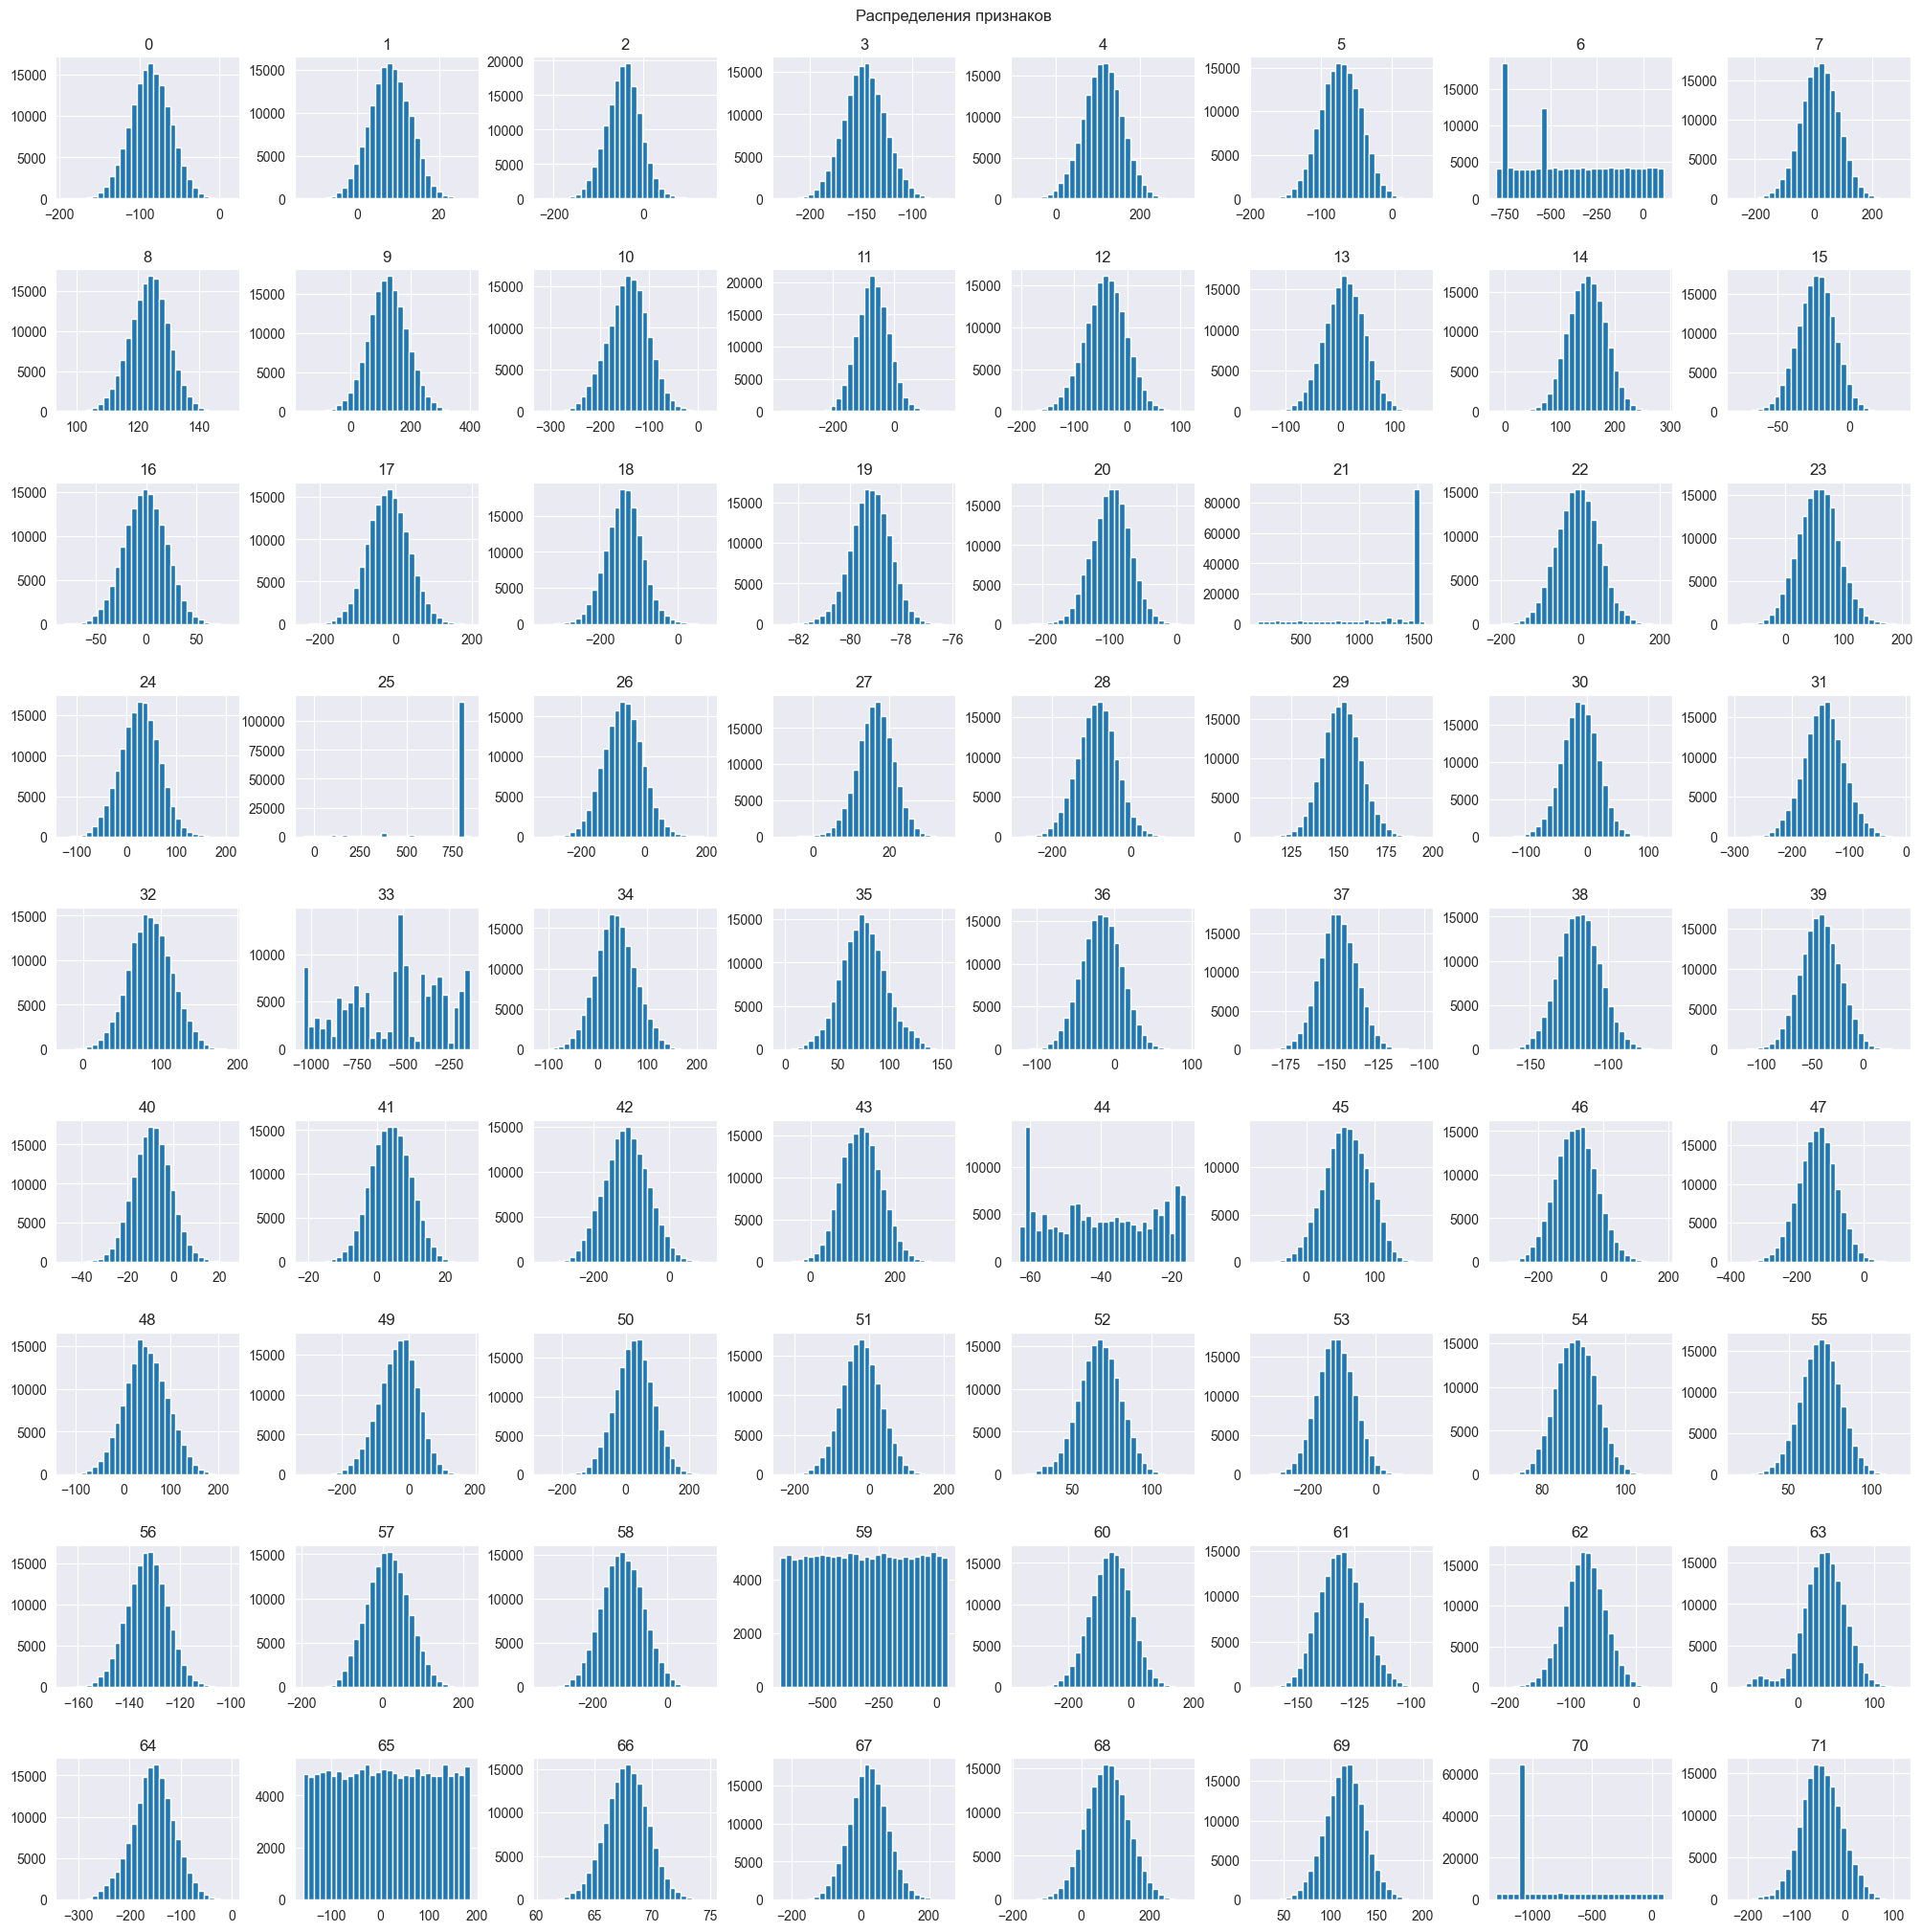

In [10]:
fig, axes = plt.subplots(nrows=9, ncols=8, figsize=(25,25))
fig.suptitle('Распределения признаков', y=0.9)
plt.subplots_adjust(hspace=0.5, wspace=0.3) # отодвигаем графики друг от друга
for i, col in enumerate(base_df.columns):
    ax = axes[i // 8, i % 8]
    ax.hist(x=base_df[col].sample(frac=0.05), bins=30)
    ax.set_ylabel('')
    ax.set_title(col)

Распределения некоторых признаков отличаются от нормального распределения. Значения признаков ненормированные, это нужно исправить.

Похоже, что ~~какой то джун испортил данные~~ в данные каким-то образом попали странные признаки

Составим список из `подозрительных` признаков. Проверим как модель будет работать с ними и без них. Если без них лучше, то удалим.

Всего признаков 72, подозратильных 8. Остается 64 признака. 

Для эмбедингов 72 признака - нетипичное значение, а 64 - типичное. Удаление этих признаков согласуется с логикой.

In [11]:
columns_to_drop = [str(i) for i in [6, 21, 25, 59, 65, 70, 33, 44]]

План действий:
- Удалить странные признаки если без них метрика будет лучше
- Нормировать данные

### Предобработка данных и проверка работы FAISS

Данные уже разбиты на трейн и тест, выделяем таргеты. Также составляем словарь, где ключи - порядковые номера датафрейма `base_df` , значения - индекс(строка) в `base_df`

In [12]:
targets_train = train_df["Target"]
train_df.drop("Target", axis=1, inplace=True)
targets_val = validation_answer_df['Expected']

Составим индекс. Первым по рекомендациям разработчиков является IVF индекс с квантованием

Для начала пусть будет 1024 кластеров, по которым будет осуществляться поиск (число велико, но мы в будущем будем обходить несколько кластеров при поиске)

Увеличение числа кластеров дает бо'льшую производительность за счет точности.

Затем подберем этот гиперпараметр

In [13]:
base_index = {k: v for k, v in enumerate(base_df.index.to_list())}
base_index_inverted = {v:k for k,v in base_index.items()}

In [14]:
dims = base_df.shape[1]
n_cells = 1024

Обучать индекс будем на 50000 векторов. Вероятно этого хватит, но нужно проверить.

Также составляем словарь, где ключи - порядковые номера датафрейма `base_df` , значения - индекс(строка) в `base_df`.

Вместо прописывания quantizer и index будем использовать укороченную запись при помощи `index_factory`

In [15]:
index = faiss.index_factory(dims, 'IVF1024,Flat') #quantizer c 1024 ячейками, Flat индекс с l2 метрикой
index.train(np.ascontiguousarray(base_df.values[:50000, :]).astype('float32'))
index.add(np.ascontiguousarray(base_df.values).astype('float32'))

In [16]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_df.values).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 17.1 s
Wall time: 3.29 s


4.244

In [17]:
scaler = QuantileTransformer(
#     output_distribution='normal'
)
base_array = scaler.fit_transform(base_df)
train_array = scaler.transform(train_df)
validation_array = scaler.transform(validation_df)

In [18]:
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:50000, :]).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))

In [19]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 5)

CPU times: total: 20.5 s
Wall time: 3.54 s


In [20]:
for i,v in enumerate(idxs):
    if -1 in v:
        idxs[i] = np.array([idx if idx != -1 else 0 for idx in v])

In [21]:
accuracy_n(targets_train, idxs)

51.942

Accuracy@5 чуть выше 4%. Стандартизируем векторы и запустим алгоритм заново

In [22]:
scaler = StandardScaler()
base_array = scaler.fit_transform(base_df)
train_array = scaler.transform(train_df)
validation_array = scaler.transform(validation_df)

In [23]:
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:50000, :]).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))

In [24]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 21.6 s
Wall time: 4.11 s


50.394

Алгоритм отработал за 4 с небольшим секунды. Стандартизация заметно улучшает метрику.

Удалим подозрительные столбцы и проверим результат.

In [25]:
base_df.drop(columns_to_drop, axis=1, inplace=True)
train_df.drop(columns_to_drop, axis=1, inplace=True)
validation_df.drop(columns_to_drop, axis=1, inplace=True)

Стандартизируем заново

In [26]:
scaler = StandardScaler()
base_array = scaler.fit_transform(base_df)
train_array = scaler.fit_transform(train_df)
validation_array = scaler.transform(validation_df)

In [27]:
dims = base_df.shape[1] #размерность векторов изменилась, переопределим переменную

In [28]:
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:50000, :]).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))

In [29]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 18.8 s
Wall time: 3.56 s


59.733

Удаление `подозрительных` признаков улучшило метрику.

Попробуем увеличить количество кластеров для поиска `nprobe`. Время работы алгоритма при этом должно увеличиться. Предполагаю, что этот гиперпараметр будет иметь схожий эффект с гиперпараметром `n_cells` - перебор бо'льшего числа векторов при увеличении времени работы.

Заодно, для успокоения души проверим действительно ли хватает 50_000 образцов для обучения индекса. Попробуем 500_000

In [30]:
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:500_000, :]).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))
index.nprobe = 32

In [31]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 6min 41s
Wall time: 1min 12s


70.381

In [32]:
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:50_000, :]).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))
index.nprobe = 32

In [33]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 7min 10s
Wall time: 1min 19s


70.392

2 метрики выше почти полностью совпадают. 50к достаточно для экспериментов, но для финальной модели будем использовать полный набор

Резюмируем:
- Больше кластеров по которым ищем - точнее поиск (т.к. правильный результат может быть в соседнем кластере). Время работы увеличивается линейно (на самом деле чуть быстрее, видимо, внутри лежат эффективные алгоритмы)
- 50к образцов для обучения достаточно
- Стандартизация сильно улучшает метрику

### Дальнейший план работы

Что делаем дальше. 

По уверениям разработчиков `Flat` индекс является довольно точным. Поэтому проведем эксперименты с различными гиперпараметрами этого индекса.
Но полностью на слово доверять не будем и проверим также другие индексы, если увидим результаты лучше, то проведем подбор гиперпараметров и для них тоже

Проверим следующий алгоритм:

Находим оптимальные гиперпараметры:
- Увеличиваем количество результатов поиска - от 5 до выхода на плато. `accuracy_n` увеличится, но осложнится последующая задача ранжирования.
- Увеличиваем nprobe - тут время будет расти линейно, получаем trade между скоростью работы и точностью алгоритма



Ранжируем результаты:
- Находим расстояния от каждого вектора из query с каждым вектором из выдачи. То же самое проделываем для валидационной выборки
- В качестве таргета добавляем лейбл 1 или 0. Делаем так для каждого вектора из query, в итоге получаем датасет из 100_000 * idxs.shape[1] строк
- Обучаем ml-модели для нахождения 1 на трейне. На выдаче получаем скоры. Следим за переобучением на валидационной выборке.
- Первые 5 скоров и будут результатом выдачи, по которым будет считаться метрика.



### Подбор гиперпараметров для FAISS

Реализуем первый шаг - найдем гиперпараметры для faiss
Пройдемся вложенным циклом и упакуем результаты в словарь. Струкрура словаря
```
metrics = {
    '5 соседей':{
        '1 кластер': [время_5_1, accuracy_train, accuracy_val], 
        '2 кластера': [время_5_2, accuracy_train, accuracy_val],
        ...,
        '128 кластеров': [время_5_2, accuracy_train, accuracy_val]
    },
    '10 соседей':{
        '1 кластер': [время_10_1, accuracy_train, accuracy_val], 
        '2 кластера': [время_10_2, accuracy_train, accuracy_val],
        ...,
        '128 кластеров': [время_10_2, accuracy_train, accuracy_val]
    },
    ...
}
```

In [34]:
# metrics = {}
# c = time.time()
# for neighbours in range(5,101,5): #ищем от 5 до 100 соседей
#     metrics[neighbours] = {}
#     for nprobe in [2**x for x in range(6)]: #ищем в разном числе кластеров
#         a = time.time()
#         index.nprobe = nprobe
#         distances_train, idxs_train = index.search(np.ascontiguousarray(train_array).astype('float32'), neighbours)
#         for i,v in enumerate(idxs_train): #заменяем -1 в ответах на 0
#             if -1 in v:
#                 idxs_train[i] = np.array([idx if idx != -1 else 0 for idx in v])
        
#         distances_val, idxs_val = index.search(np.ascontiguousarray(validation_array).astype('float32'), neighbours)
#         for i,v in enumerate(idxs_val):
#             if -1 in v:
#                 idxs_val[i] = np.array([idx if idx != -1 else 0 for idx in v])
            
#         b = time.time()
# #         отслеживаем прогресс поиска гиперпараметров с обновляемым выводом
#         print((f'\rОбработан запрос: neighbours = {neighbours},'
#                f'nprobe = {nprobe}, общее время выполнения {b-c:.2f} секунд'), end='')
#         metrics[neighbours][nprobe] = [f'Затраченное время = {(b-a)/2:.2f} секунд',\
#                                        accuracy_n(targets_train, idxs_train), accuracy_n(targets_val, idxs_val)]

Чтобы не запускать ячейку выше - сохраним результаты экспериментов в json-файл. Саму ячейку пока закомментируем (в репозитории будет раскомментирована, выполняется долго)

Вывод ячейки:
Обработан запрос: neighbours = 100,nprobe = 32, общее время выполнения 6775.33 секунд

In [35]:
# with open('datasets/metrics_faiss.json', "w", encoding="utf-8") as file:
#     json.dump(metrics, file)

In [36]:
metrics = json.load(open('datasets/metrics_faiss.json'))
metrics

{'5': {'1': ['Затраченное время = 3.71 секунд', 59.733, 59.902],
  '2': ['Затраченное время = 6.52 секунд', 65.091, 65.126],
  '4': ['Затраченное время = 11.72 секунд', 67.644, 67.735],
  '8': ['Затраченное время = 21.78 секунд', 69.125, 69.108],
  '16': ['Затраченное время = 41.04 секунд', 69.938, 69.949],
  '32': ['Затраченное время = 79.44 секунд', 70.392, 70.35]},
 '10': {'1': ['Затраченное время = 3.70 секунд', 61.364, 61.501],
  '2': ['Затраченное время = 6.55 секунд', 67.087, 67.047],
  '4': ['Затраченное время = 11.79 секунд', 69.904, 69.944],
  '8': ['Затраченное время = 21.48 секунд', 71.57, 71.539],
  '16': ['Затраченное время = 39.36 секунд', 72.518, 72.536],
  '32': ['Затраченное время = 75.66 секунд', 73.055, 73.032]},
 '15': {'1': ['Затраченное время = 3.57 секунд', 62.127, 62.259],
  '2': ['Затраченное время = 6.35 секунд', 68.007, 67.99],
  '4': ['Затраченное время = 11.27 секунд', 70.936, 70.996],
  '8': ['Затраченное время = 20.81 секунд', 72.706, 72.709],
  '16': ['

Валидация сильно не отличается. Вероятно, распределение train и val схожи. Построим графики по трейну.

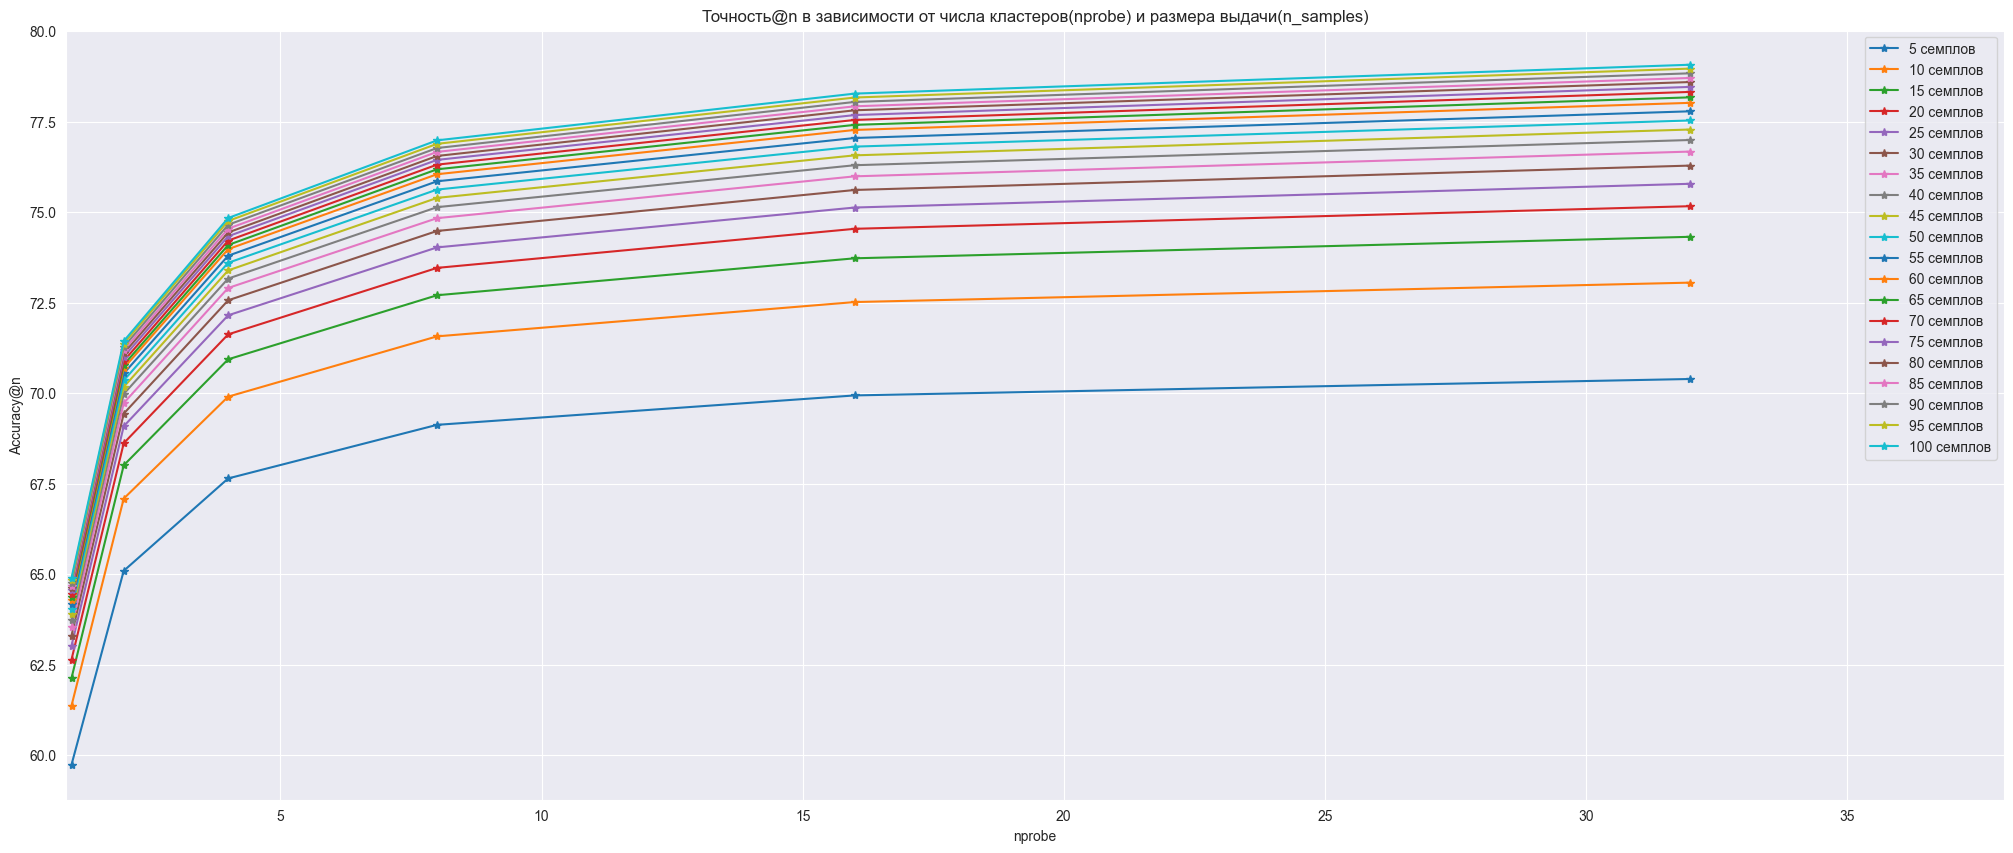

In [37]:
fig, ax = plt.subplots(1, figsize=(25, 10))
for n_samples in metrics.keys():
    y = [i[1] for i in metrics[n_samples].values()]
    x = [int(i) for i in metrics[n_samples].keys()]
    ax.plot(x,y, marker='*', label=f'{n_samples} семплов')
plt.xlim(0.9, 38)
plt.ylabel('Accuracy@n')
plt.xlabel('nprobe')
plt.title('Точность@n в зависимости от числа кластеров(nprobe) и размера выдачи(n_samples)')
ax.legend()
plt.show()

Выдача бо'льшего количества семплов не увеличивает время, но, вероятно, будет ухудшать результаты модели ранжирования (гораздо проще отобрать 5 правильных кандидатов из 30 семплов, чем 5 кандидатов из 100 семплов)

С увеличением nprobe время увеличивается линейно. Поиск по 32 кластерам не дает ощутимого прироста. 40 секунд - ок, 1,5 минуты уже долго. поэтому оставляем nprobe 16. Но если ресурсы позволят запустить в прод модель потяжелее - запустим хоть 1024(перемножим все вектора со всеми)

### Поиск оптимального индекса для задачи

Мы рассмотрели только Flat индекс с разбиением на кластеры. Посмотрим другие индексы. 

По хорошему нужно перебрать множество гиперпараметров, но в цикле по примеру выше это делать долго. Поэтому некоторые эксперименты оставлены `за кадром`. Оценивать будем с полученным бенчмарком в т.ч. и по скорости работы.

Сравнивать будем по 50 соседям и nprobe 16

In [38]:
metrics['50']['16']

['Затраченное время = 39.28 секунд', 76.813, 76.808]

#### IndexFlatIP

In [39]:
quantizer = faiss.IndexFlatIP(dims)
index = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [40]:
%%time
index.train(np.ascontiguousarray(base_array).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))
index.nprobe = 16

CPU times: total: 28.7 s
Wall time: 7.12 s


In [41]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 50)
accuracy_n(targets_train, idxs)

CPU times: total: 5min 1s
Wall time: 60 s


77.028

- Обучение индекса быстрое.
- Результат по сравнимому `nprobe` лучше, чем у бенчмарка
- Но за это же время мы можем перебрать в 2 раза больше кластеров у бенчмарка и получить метрику лучше

Вывод: индекс показал себя хуже

#### IVFADC Индекс

In [42]:
%%time
index = faiss.index_factory(dims, 'IVF1024,PQ16')
index.train(np.ascontiguousarray(base_array).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))
index.nprobe = 16

CPU times: total: 1min 45s
Wall time: 22 s


In [43]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 50)
accuracy_n(targets_train, idxs)

CPU times: total: 50 s
Wall time: 10.6 s


76.654

- Обучение индекса длится дольше.
- Результат по сравнимому `nprobe` хуже, чем у бенчмарка.
- Работает в 3 раза быстрее, можем перебрать больше кластеров за сопоставимое время

Вывод: кандидат на замену бенчмарку

#### HNSWFlat Индекс

Разработчики рекомендуют использовать индекс для 1М-10М датасетов. Как раз наш случай. Проверим

In [44]:
%%time
index = faiss.index_factory(dims,'IVF1024_HNSW32,Flat')
index.train(np.ascontiguousarray(base_array).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))

CPU times: total: 52.3 s
Wall time: 11.3 s


In [45]:
index.nprobe = 16

In [46]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 50)

CPU times: total: 3min 36s
Wall time: 40.5 s


In [47]:
accuracy_n(targets_train, idxs)

76.151

- Обучение заметно дольше
- Результат приблизительно тот же
- Время поиска немного дольше

Вывод: не подходит на замену, возможно, требует больше экспериментов

#### HNSW

Этот индекс быстрее. efSearch зададим больше чем 16

In [48]:
%%time
index = faiss.index_factory(dims,'HNSW')
index.train(np.ascontiguousarray(base_array).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))

CPU times: total: 13min 55s
Wall time: 2min 38s


In [49]:
index.hnsw.efSearch = 512

In [50]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 50)
accuracy_n(targets_train, idxs)

CPU times: total: 2min 55s
Wall time: 33.5 s


76.066

- Долгое обучение индекса
- Результат хуже
- Время поиска немного быстрее

Вывод: возможно, требует больше экспериментов

Общий вывод:

Пока будем использовать Flat индекс с 1024 кластерами. Если останется время - поэкспериментируем еще

### Ранжирование результатов

Для ранжирования результатов будем использовать классификатор с методом `predict_proba`. Нужно научить классификатор правильно определять совпадающие товары.

- Составим обучающий датасет, в котором посчитаем расстояния от искомого вектора до совпадающего вектора. Проставим лейбл 1
- Добавим в датасет расстояния от искомого вектора до рандомного вектора base_array. Проставим лейбл 0.
- Пока не будем заниматься подбором гиперпараметров (пусть даже переобучимся!), а просто поэкспериментируем. Логичным кажется максимизировать `precision` (но recall тоже посмотрим), т.к. нам важно штрафовать False Positive и не страшно получать False Negstive, ведь все равно из результатов модели мы будем вытягивать скоры, а не 0 и 1. 

Данные разобьем 80/20, на 20% считаем метрику.
- Для каждого алгоритма посмотрим на результат ранжирования на трейне! Почему не на валидационной? 
    - Потому что векторы, которые будут сгенерированы Faiss'ом будут отличаться от фичей, которые мы сгенерировали 
    - Потому что если алгоритм не покажет себя даже на тренировочной выборке, то нет никакого смысла смотреть валидационную.
- Увидим результат - будем тюнить с помощью кросс-валидации, следить за переобучением и смотреть на валидацию (то есть будем считать нашу валидационную выборку тестовой)

In [261]:
index = faiss.index_factory(dims,'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))
index.nprobe = 32

In [314]:
%%time
distances_5, idxs_5 = index.search(np.ascontiguousarray(train_array).astype('float32'), 5)
accuracy_n(targets_train, idxs_5)

CPU times: total: 6min 42s
Wall time: 1min 16s


70.439

In [317]:
%%time
distances_val, idxs_val_5 = index.search(np.ascontiguousarray(validation_array).astype('float32'), 5)
accuracy_n(targets_val, idxs_val_5)

CPU times: total: 6min 43s
Wall time: 1min 16s


70.355

Если получим метрику ниже этой, то классификатор отбрасываем

In [263]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 10)
accuracy_n(targets_train, idxs)

CPU times: total: 6min 47s
Wall time: 1min 15s


73.101

In [307]:
%%time
distances_val, idxs_val = index.search(np.ascontiguousarray(validation_array).astype('float32'), 10)
accuracy_n(targets_val, idxs_val)

CPU times: total: 6min 48s
Wall time: 1min 13s


73.048

Это наш верхний порог. Если итоговое значение выше нижнего порога, то ранжирование удалось

In [264]:
features = []
target = []
for vec_1, index_target in tqdm(zip(train_array, targets_train.values)):
    vec_2 = base_array[base_index_inverted[index_target]]
    distance_list = get_distances(vec_1, vec_2)
    features.append(distance_list)
    target.append(1)
    vec_3 = base_array[np.random.randint(base_array.shape[0])]
    distance_list = get_distances(vec_1, vec_3)
    features.append(distance_list)
    target.append(0)
features = np.array(features)
target = np.array(target)

100000it [00:42, 2359.96it/s]


In [265]:
x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.2)

##### LogisticRegression

In [266]:
model = LogisticRegression(max_iter=10000)
model.fit(x_train,y_train)

LogisticRegression(max_iter=10000)

In [267]:
preds = model.predict(x_test)

print(precision_score(y_test,preds))
print(recall_score(y_test,preds))

0.9834910733491073
0.9219175320092752


Теперь вычислим расстояния от искомого вектора до каждого из 10 соседей. Выделим 5 наиболее близких и проверим метрику

In [268]:
%%time
result = []
for i, candidates in enumerate(idxs):
    query = train_array[i] #искомый вектор
    query_features = make_features(candidates, query) #массив с расстояниями
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)
    print(f'\rОбработан {i+1} запрос', end='')
print()

Обработан 100000 запрос
CPU times: total: 3min 41s
Wall time: 3min 41s


In [269]:
accuracy_n(targets_train, np.array(result))

70.473

Вывод:

Метрика для отранжированных 10 кандидатов даже на трейне сопоставима с простым поиском по 5 кандидатам. Плюс затрачено 3,5 минуты времени на генерацию фич и работу модели. 

Такой подход не годится. За те же самые 3,5 минуты мы могли бы обойти в несколько раз больше кластеров в индексе и получить метрику выше.

##### CatBoostClassifier

In [270]:
model = CatBoostClassifier(random_state=42)
model.fit(x_train,y_train)

Learning rate set to 0.089969
0:	learn: 0.5332343	total: 91.4ms	remaining: 1m 31s
1:	learn: 0.4246542	total: 108ms	remaining: 53.9s
2:	learn: 0.3379584	total: 124ms	remaining: 41.1s
3:	learn: 0.2752370	total: 139ms	remaining: 34.6s
4:	learn: 0.2380811	total: 153ms	remaining: 30.5s
5:	learn: 0.2122740	total: 193ms	remaining: 31.9s
6:	learn: 0.1945480	total: 211ms	remaining: 29.9s
7:	learn: 0.1819632	total: 225ms	remaining: 27.9s
8:	learn: 0.1718015	total: 239ms	remaining: 26.3s
9:	learn: 0.1633701	total: 254ms	remaining: 25.2s
10:	learn: 0.1563895	total: 271ms	remaining: 24.4s
11:	learn: 0.1514818	total: 285ms	remaining: 23.5s
12:	learn: 0.1472663	total: 300ms	remaining: 22.8s
13:	learn: 0.1440727	total: 314ms	remaining: 22.1s
14:	learn: 0.1416046	total: 329ms	remaining: 21.6s
15:	learn: 0.1397426	total: 344ms	remaining: 21.2s
16:	learn: 0.1382532	total: 360ms	remaining: 20.8s
17:	learn: 0.1369841	total: 374ms	remaining: 20.4s
18:	learn: 0.1359619	total: 390ms	remaining: 20.2s
19:	learn

161:	learn: 0.1241078	total: 2.57s	remaining: 13.3s
162:	learn: 0.1240775	total: 2.59s	remaining: 13.3s
163:	learn: 0.1240618	total: 2.6s	remaining: 13.3s
164:	learn: 0.1240333	total: 2.62s	remaining: 13.3s
165:	learn: 0.1240004	total: 2.63s	remaining: 13.2s
166:	learn: 0.1239559	total: 2.65s	remaining: 13.2s
167:	learn: 0.1239335	total: 2.66s	remaining: 13.2s
168:	learn: 0.1238911	total: 2.68s	remaining: 13.2s
169:	learn: 0.1238553	total: 2.69s	remaining: 13.1s
170:	learn: 0.1238222	total: 2.71s	remaining: 13.1s
171:	learn: 0.1237999	total: 2.72s	remaining: 13.1s
172:	learn: 0.1237721	total: 2.74s	remaining: 13.1s
173:	learn: 0.1237386	total: 2.75s	remaining: 13.1s
174:	learn: 0.1237097	total: 2.77s	remaining: 13s
175:	learn: 0.1236866	total: 2.78s	remaining: 13s
176:	learn: 0.1236610	total: 2.79s	remaining: 13s
177:	learn: 0.1236367	total: 2.81s	remaining: 13s
178:	learn: 0.1235961	total: 2.82s	remaining: 13s
179:	learn: 0.1235643	total: 2.84s	remaining: 12.9s
180:	learn: 0.1235364	t

330:	learn: 0.1197366	total: 5.14s	remaining: 10.4s
331:	learn: 0.1197283	total: 5.15s	remaining: 10.4s
332:	learn: 0.1197044	total: 5.17s	remaining: 10.3s
333:	learn: 0.1196735	total: 5.18s	remaining: 10.3s
334:	learn: 0.1196608	total: 5.19s	remaining: 10.3s
335:	learn: 0.1196484	total: 5.21s	remaining: 10.3s
336:	learn: 0.1196284	total: 5.22s	remaining: 10.3s
337:	learn: 0.1196051	total: 5.24s	remaining: 10.3s
338:	learn: 0.1195805	total: 5.26s	remaining: 10.3s
339:	learn: 0.1195702	total: 5.27s	remaining: 10.2s
340:	learn: 0.1195543	total: 5.29s	remaining: 10.2s
341:	learn: 0.1195111	total: 5.3s	remaining: 10.2s
342:	learn: 0.1194881	total: 5.32s	remaining: 10.2s
343:	learn: 0.1194698	total: 5.33s	remaining: 10.2s
344:	learn: 0.1194438	total: 5.35s	remaining: 10.2s
345:	learn: 0.1194188	total: 5.37s	remaining: 10.1s
346:	learn: 0.1193887	total: 5.38s	remaining: 10.1s
347:	learn: 0.1193695	total: 5.4s	remaining: 10.1s
348:	learn: 0.1193650	total: 5.42s	remaining: 10.1s
349:	learn: 0.

500:	learn: 0.1162444	total: 7.71s	remaining: 7.68s
501:	learn: 0.1162268	total: 7.73s	remaining: 7.67s
502:	learn: 0.1162088	total: 7.74s	remaining: 7.65s
503:	learn: 0.1161789	total: 7.76s	remaining: 7.63s
504:	learn: 0.1161606	total: 7.77s	remaining: 7.62s
505:	learn: 0.1161234	total: 7.79s	remaining: 7.6s
506:	learn: 0.1161007	total: 7.8s	remaining: 7.58s
507:	learn: 0.1160661	total: 7.81s	remaining: 7.57s
508:	learn: 0.1160663	total: 7.83s	remaining: 7.55s
509:	learn: 0.1160540	total: 7.84s	remaining: 7.53s
510:	learn: 0.1160469	total: 7.85s	remaining: 7.51s
511:	learn: 0.1160191	total: 7.87s	remaining: 7.5s
512:	learn: 0.1160073	total: 7.88s	remaining: 7.48s
513:	learn: 0.1160073	total: 7.89s	remaining: 7.46s
514:	learn: 0.1160073	total: 7.9s	remaining: 7.44s
515:	learn: 0.1160072	total: 7.91s	remaining: 7.42s
516:	learn: 0.1160074	total: 7.92s	remaining: 7.4s
517:	learn: 0.1160071	total: 7.94s	remaining: 7.38s
518:	learn: 0.1160073	total: 7.95s	remaining: 7.37s
519:	learn: 0.116

676:	learn: 0.1160072	total: 9.88s	remaining: 4.71s
677:	learn: 0.1160072	total: 9.89s	remaining: 4.7s
678:	learn: 0.1160072	total: 9.9s	remaining: 4.68s
679:	learn: 0.1160072	total: 9.91s	remaining: 4.67s
680:	learn: 0.1160072	total: 9.93s	remaining: 4.65s
681:	learn: 0.1160072	total: 9.94s	remaining: 4.63s
682:	learn: 0.1160072	total: 9.95s	remaining: 4.62s
683:	learn: 0.1160072	total: 9.96s	remaining: 4.6s
684:	learn: 0.1160072	total: 9.97s	remaining: 4.58s
685:	learn: 0.1160072	total: 9.98s	remaining: 4.57s
686:	learn: 0.1160072	total: 10s	remaining: 4.55s
687:	learn: 0.1160072	total: 10s	remaining: 4.54s
688:	learn: 0.1160072	total: 10s	remaining: 4.52s
689:	learn: 0.1160072	total: 10s	remaining: 4.51s
690:	learn: 0.1160072	total: 10.1s	remaining: 4.49s
691:	learn: 0.1160072	total: 10.1s	remaining: 4.48s
692:	learn: 0.1160072	total: 10.1s	remaining: 4.46s
693:	learn: 0.1160072	total: 10.1s	remaining: 4.45s
694:	learn: 0.1160072	total: 10.1s	remaining: 4.43s
695:	learn: 0.1160072	t

842:	learn: 0.1160072	total: 12s	remaining: 2.23s
843:	learn: 0.1160072	total: 12s	remaining: 2.22s
844:	learn: 0.1160072	total: 12s	remaining: 2.21s
845:	learn: 0.1160072	total: 12s	remaining: 2.19s
846:	learn: 0.1160072	total: 12.1s	remaining: 2.18s
847:	learn: 0.1160072	total: 12.1s	remaining: 2.16s
848:	learn: 0.1160072	total: 12.1s	remaining: 2.15s
849:	learn: 0.1160072	total: 12.1s	remaining: 2.13s
850:	learn: 0.1160072	total: 12.1s	remaining: 2.12s
851:	learn: 0.1160072	total: 12.1s	remaining: 2.1s
852:	learn: 0.1160072	total: 12.1s	remaining: 2.09s
853:	learn: 0.1160072	total: 12.1s	remaining: 2.08s
854:	learn: 0.1160072	total: 12.2s	remaining: 2.06s
855:	learn: 0.1160072	total: 12.2s	remaining: 2.05s
856:	learn: 0.1160072	total: 12.2s	remaining: 2.03s
857:	learn: 0.1160072	total: 12.2s	remaining: 2.02s
858:	learn: 0.1160072	total: 12.2s	remaining: 2s
859:	learn: 0.1160072	total: 12.2s	remaining: 1.99s
860:	learn: 0.1160072	total: 12.2s	remaining: 1.97s
861:	learn: 0.1160072	to

In [271]:
preds = model.predict(x_test)

print(precision_score(y_test,preds))
print(recall_score(y_test,preds))

0.9847081628257592
0.9218671237019861


In [272]:
%%time
result = []
for i, candidates in enumerate(idxs[:1000]):
    query = train_array[i]
    query_features = make_features(candidates, query)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)
    print(f'\rОбработан {i+1} запрос', end='')
print()

Обработан 1000 запрос
CPU times: total: 2.88 s
Wall time: 2.51 s


In [273]:
accuracy_n(targets_train, np.array(result))

68.2

Результат хуже чем на 5 кандидатах

##### RandomForestClassifier

In [274]:
%%time
model = RandomForestClassifier(n_estimators = 100, random_state=42, n_jobs=-1)
model.fit(x_train,y_train)

CPU times: total: 2min 58s
Wall time: 32.6 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [275]:
preds = model.predict(x_test)

print(precision_score(y_test,preds))
print(recall_score(y_test,preds))

0.98414660361135
0.9231273313842121


In [276]:
%%time
result = []
for i, candidates in enumerate(idxs[:1000]):
    query = train_array[i]
    query_features = make_features(candidates, query)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)
    print(f'\rОбработан {i+1} запрос', end='')
print()

Обработан 1000 запрос
CPU times: total: 21.1 s
Wall time: 34.6 s


In [277]:
accuracy_n(targets_train, np.array(result))

69.6

In [278]:
accuracy_n(targets_train, idxs_5[:1000])

72.7

Мы сгенерили слишком простую обучающую выборку в самом начале. Поэтому искомый вектор от рандомного разделяются довольно неплохо, но на реальных данных все печально.

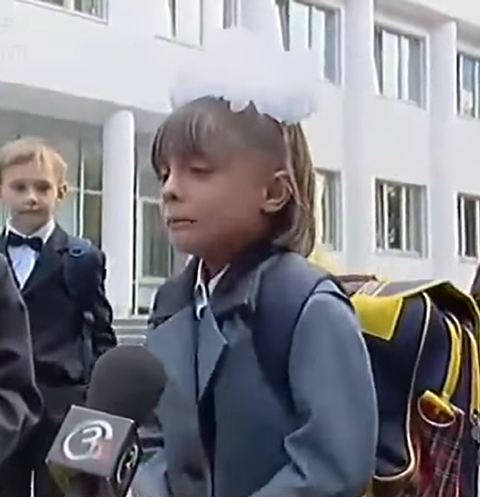
И шарик не дали...

#### Генерация более сложной выборки

Сделаем обучающую выборку на результатах faiss. Векторы будут схожими, научить классификатор разделять их будет сложнее

In [279]:
features = []
target = []
for i, candidates in tqdm(enumerate(idxs)):
    vec_1 = train_array[i]
    for candidate in candidates:
        vec_2 = base_array[candidate]
        current_distances = get_distances(vec_1,vec_2)
        if targets_train[i] == base_index[candidate]:
            target.append(1)
        else:
            target.append(0)
        features.append(current_distances)

100000it [03:30, 474.71it/s]


In [288]:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2, 
                                                    stratify=target, 
                                                    random_state=42)

In [293]:
model = LogisticRegression(
    max_iter=100000, 
#     class_weight='balanced'
)
model.fit(x_train,y_train)

LogisticRegression(max_iter=100000)

In [294]:
preds = model.predict(x_test)

print(precision_score(y_test,preds))
print(recall_score(y_test,preds))

0.5547180092634638
0.4177838577291382


Логистическая регрессия довольно плохо разделяет близкие векторы по их расстояниям. Проверять ранжирование не будем

In [296]:
from catboost import Pool

In [297]:
eval_data = Pool(
    data=x_test,
    label=y_test
)

In [298]:
model = CatBoostClassifier(random_state=42)
model.fit(x_train,y_train, eval_set=eval_data)

Learning rate set to 0.165186
0:	learn: 0.4691168	test: 0.4692517	best: 0.4692517 (0)	total: 55.1ms	remaining: 55s
1:	learn: 0.3409586	test: 0.3410056	best: 0.3410056 (1)	total: 107ms	remaining: 53.4s
2:	learn: 0.2697120	test: 0.2699323	best: 0.2699323 (2)	total: 168ms	remaining: 56s
3:	learn: 0.2280203	test: 0.2282457	best: 0.2282457 (3)	total: 230ms	remaining: 57.2s
4:	learn: 0.2042792	test: 0.2045182	best: 0.2045182 (4)	total: 286ms	remaining: 57s
5:	learn: 0.1884443	test: 0.1888184	best: 0.1888184 (5)	total: 337ms	remaining: 55.9s
6:	learn: 0.1788009	test: 0.1791383	best: 0.1791383 (6)	total: 387ms	remaining: 54.9s
7:	learn: 0.1725442	test: 0.1729302	best: 0.1729302 (7)	total: 436ms	remaining: 54.1s
8:	learn: 0.1685001	test: 0.1689028	best: 0.1689028 (8)	total: 496ms	remaining: 54.6s
9:	learn: 0.1660325	test: 0.1664802	best: 0.1664802 (9)	total: 546ms	remaining: 54s
10:	learn: 0.1643991	test: 0.1648172	best: 0.1648172 (10)	total: 599ms	remaining: 53.9s
11:	learn: 0.1629524	test: 0.

97:	learn: 0.1526852	test: 0.1537405	best: 0.1537405 (97)	total: 6.31s	remaining: 58.1s
98:	learn: 0.1526528	test: 0.1537177	best: 0.1537177 (98)	total: 6.38s	remaining: 58.1s
99:	learn: 0.1526193	test: 0.1536910	best: 0.1536910 (99)	total: 6.44s	remaining: 57.9s
100:	learn: 0.1525750	test: 0.1536625	best: 0.1536625 (100)	total: 6.49s	remaining: 57.8s
101:	learn: 0.1525306	test: 0.1536325	best: 0.1536325 (101)	total: 6.55s	remaining: 57.7s
102:	learn: 0.1524840	test: 0.1535909	best: 0.1535909 (102)	total: 6.61s	remaining: 57.5s
103:	learn: 0.1524331	test: 0.1535352	best: 0.1535352 (103)	total: 6.67s	remaining: 57.4s
104:	learn: 0.1523884	test: 0.1535135	best: 0.1535135 (104)	total: 6.73s	remaining: 57.4s
105:	learn: 0.1523602	test: 0.1534987	best: 0.1534987 (105)	total: 6.81s	remaining: 57.4s
106:	learn: 0.1523293	test: 0.1534711	best: 0.1534711 (106)	total: 6.88s	remaining: 57.4s
107:	learn: 0.1522930	test: 0.1534459	best: 0.1534459 (107)	total: 6.94s	remaining: 57.3s
108:	learn: 0.15

192:	learn: 0.1496360	test: 0.1515484	best: 0.1515456 (191)	total: 12.2s	remaining: 50.9s
193:	learn: 0.1496215	test: 0.1515442	best: 0.1515442 (193)	total: 12.2s	remaining: 50.8s
194:	learn: 0.1496039	test: 0.1515321	best: 0.1515321 (194)	total: 12.3s	remaining: 50.8s
195:	learn: 0.1495863	test: 0.1515290	best: 0.1515290 (195)	total: 12.4s	remaining: 50.7s
196:	learn: 0.1495678	test: 0.1515282	best: 0.1515282 (196)	total: 12.4s	remaining: 50.6s
197:	learn: 0.1495435	test: 0.1515188	best: 0.1515188 (197)	total: 12.5s	remaining: 50.6s
198:	learn: 0.1495254	test: 0.1515117	best: 0.1515117 (198)	total: 12.5s	remaining: 50.5s
199:	learn: 0.1495135	test: 0.1515101	best: 0.1515101 (199)	total: 12.6s	remaining: 50.4s
200:	learn: 0.1494947	test: 0.1515084	best: 0.1515084 (200)	total: 12.7s	remaining: 50.3s
201:	learn: 0.1494638	test: 0.1514877	best: 0.1514877 (201)	total: 12.7s	remaining: 50.2s
202:	learn: 0.1494451	test: 0.1514827	best: 0.1514827 (202)	total: 12.8s	remaining: 50.2s
203:	learn

287:	learn: 0.1477405	test: 0.1504884	best: 0.1504884 (287)	total: 17.9s	remaining: 44.4s
288:	learn: 0.1477272	test: 0.1504717	best: 0.1504717 (288)	total: 18s	remaining: 44.3s
289:	learn: 0.1477063	test: 0.1504580	best: 0.1504580 (289)	total: 18.1s	remaining: 44.2s
290:	learn: 0.1476974	test: 0.1504583	best: 0.1504580 (289)	total: 18.1s	remaining: 44.2s
291:	learn: 0.1476883	test: 0.1504535	best: 0.1504535 (291)	total: 18.2s	remaining: 44.1s
292:	learn: 0.1476727	test: 0.1504500	best: 0.1504500 (292)	total: 18.3s	remaining: 44.1s
293:	learn: 0.1476581	test: 0.1504484	best: 0.1504484 (293)	total: 18.3s	remaining: 44s
294:	learn: 0.1476434	test: 0.1504418	best: 0.1504418 (294)	total: 18.4s	remaining: 43.9s
295:	learn: 0.1476159	test: 0.1504272	best: 0.1504272 (295)	total: 18.4s	remaining: 43.9s
296:	learn: 0.1476071	test: 0.1504244	best: 0.1504244 (296)	total: 18.5s	remaining: 43.8s
297:	learn: 0.1475837	test: 0.1504178	best: 0.1504178 (297)	total: 18.5s	remaining: 43.7s
298:	learn: 0.

382:	learn: 0.1464160	test: 0.1499603	best: 0.1499603 (382)	total: 23.9s	remaining: 38.5s
383:	learn: 0.1464051	test: 0.1499587	best: 0.1499587 (383)	total: 23.9s	remaining: 38.4s
384:	learn: 0.1463934	test: 0.1499660	best: 0.1499587 (383)	total: 24s	remaining: 38.4s
385:	learn: 0.1463861	test: 0.1499660	best: 0.1499587 (383)	total: 24.1s	remaining: 38.3s
386:	learn: 0.1463743	test: 0.1499594	best: 0.1499587 (383)	total: 24.1s	remaining: 38.2s
387:	learn: 0.1463474	test: 0.1499481	best: 0.1499481 (387)	total: 24.2s	remaining: 38.2s
388:	learn: 0.1463406	test: 0.1499448	best: 0.1499448 (388)	total: 24.3s	remaining: 38.1s
389:	learn: 0.1463341	test: 0.1499434	best: 0.1499434 (389)	total: 24.3s	remaining: 38.1s
390:	learn: 0.1463274	test: 0.1499415	best: 0.1499415 (390)	total: 24.4s	remaining: 38s
391:	learn: 0.1463214	test: 0.1499410	best: 0.1499410 (391)	total: 24.5s	remaining: 37.9s
392:	learn: 0.1462963	test: 0.1499255	best: 0.1499255 (392)	total: 24.5s	remaining: 37.9s
393:	learn: 0.

476:	learn: 0.1451478	test: 0.1493240	best: 0.1493232 (475)	total: 29.7s	remaining: 32.6s
477:	learn: 0.1451200	test: 0.1493154	best: 0.1493154 (477)	total: 29.8s	remaining: 32.5s
478:	learn: 0.1451035	test: 0.1493040	best: 0.1493040 (478)	total: 29.8s	remaining: 32.5s
479:	learn: 0.1450889	test: 0.1493038	best: 0.1493038 (479)	total: 29.9s	remaining: 32.4s
480:	learn: 0.1450769	test: 0.1492973	best: 0.1492973 (480)	total: 30s	remaining: 32.3s
481:	learn: 0.1450528	test: 0.1492820	best: 0.1492820 (481)	total: 30s	remaining: 32.3s
482:	learn: 0.1450381	test: 0.1492754	best: 0.1492754 (482)	total: 30.1s	remaining: 32.2s
483:	learn: 0.1450219	test: 0.1492672	best: 0.1492672 (483)	total: 30.1s	remaining: 32.1s
484:	learn: 0.1450114	test: 0.1492618	best: 0.1492618 (484)	total: 30.2s	remaining: 32.1s
485:	learn: 0.1450015	test: 0.1492544	best: 0.1492544 (485)	total: 30.3s	remaining: 32s
486:	learn: 0.1449841	test: 0.1492400	best: 0.1492400 (486)	total: 30.3s	remaining: 31.9s
487:	learn: 0.14

571:	learn: 0.1440479	test: 0.1488781	best: 0.1488764 (569)	total: 35.4s	remaining: 26.5s
572:	learn: 0.1440381	test: 0.1488811	best: 0.1488764 (569)	total: 35.5s	remaining: 26.4s
573:	learn: 0.1440312	test: 0.1488789	best: 0.1488764 (569)	total: 35.5s	remaining: 26.4s
574:	learn: 0.1440206	test: 0.1488722	best: 0.1488722 (574)	total: 35.6s	remaining: 26.3s
575:	learn: 0.1440099	test: 0.1488666	best: 0.1488666 (575)	total: 35.7s	remaining: 26.3s
576:	learn: 0.1440017	test: 0.1488618	best: 0.1488618 (576)	total: 35.7s	remaining: 26.2s
577:	learn: 0.1439856	test: 0.1488504	best: 0.1488504 (577)	total: 35.8s	remaining: 26.1s
578:	learn: 0.1439740	test: 0.1488517	best: 0.1488504 (577)	total: 35.8s	remaining: 26.1s
579:	learn: 0.1439695	test: 0.1488524	best: 0.1488504 (577)	total: 35.9s	remaining: 26s
580:	learn: 0.1439556	test: 0.1488504	best: 0.1488504 (577)	total: 36s	remaining: 26s
581:	learn: 0.1439418	test: 0.1488475	best: 0.1488475 (581)	total: 36.1s	remaining: 25.9s
582:	learn: 0.14

666:	learn: 0.1432008	test: 0.1488245	best: 0.1488207 (664)	total: 41.6s	remaining: 20.8s
667:	learn: 0.1431988	test: 0.1488253	best: 0.1488207 (664)	total: 41.7s	remaining: 20.7s
668:	learn: 0.1431856	test: 0.1488299	best: 0.1488207 (664)	total: 41.7s	remaining: 20.7s
669:	learn: 0.1431705	test: 0.1488247	best: 0.1488207 (664)	total: 41.8s	remaining: 20.6s
670:	learn: 0.1431602	test: 0.1488233	best: 0.1488207 (664)	total: 41.9s	remaining: 20.5s
671:	learn: 0.1431458	test: 0.1488209	best: 0.1488207 (664)	total: 41.9s	remaining: 20.5s
672:	learn: 0.1431337	test: 0.1488262	best: 0.1488207 (664)	total: 42s	remaining: 20.4s
673:	learn: 0.1431286	test: 0.1488271	best: 0.1488207 (664)	total: 42.1s	remaining: 20.4s
674:	learn: 0.1431226	test: 0.1488283	best: 0.1488207 (664)	total: 42.1s	remaining: 20.3s
675:	learn: 0.1431123	test: 0.1488266	best: 0.1488207 (664)	total: 42.2s	remaining: 20.2s
676:	learn: 0.1431026	test: 0.1488314	best: 0.1488207 (664)	total: 42.3s	remaining: 20.2s
677:	learn: 

761:	learn: 0.1423586	test: 0.1486282	best: 0.1486278 (757)	total: 47.6s	remaining: 14.9s
762:	learn: 0.1423480	test: 0.1486321	best: 0.1486278 (757)	total: 47.7s	remaining: 14.8s
763:	learn: 0.1423442	test: 0.1486347	best: 0.1486278 (757)	total: 47.8s	remaining: 14.8s
764:	learn: 0.1423391	test: 0.1486350	best: 0.1486278 (757)	total: 47.8s	remaining: 14.7s
765:	learn: 0.1423292	test: 0.1486321	best: 0.1486278 (757)	total: 47.9s	remaining: 14.6s
766:	learn: 0.1423194	test: 0.1486361	best: 0.1486278 (757)	total: 47.9s	remaining: 14.6s
767:	learn: 0.1423059	test: 0.1486283	best: 0.1486278 (757)	total: 48s	remaining: 14.5s
768:	learn: 0.1422992	test: 0.1486212	best: 0.1486212 (768)	total: 48.1s	remaining: 14.4s
769:	learn: 0.1422896	test: 0.1486230	best: 0.1486212 (768)	total: 48.1s	remaining: 14.4s
770:	learn: 0.1422817	test: 0.1486252	best: 0.1486212 (768)	total: 48.2s	remaining: 14.3s
771:	learn: 0.1422788	test: 0.1486264	best: 0.1486212 (768)	total: 48.3s	remaining: 14.3s
772:	learn: 

855:	learn: 0.1416595	test: 0.1485524	best: 0.1485524 (855)	total: 53.6s	remaining: 9.01s
856:	learn: 0.1416529	test: 0.1485485	best: 0.1485485 (856)	total: 53.6s	remaining: 8.95s
857:	learn: 0.1416496	test: 0.1485481	best: 0.1485481 (857)	total: 53.7s	remaining: 8.89s
858:	learn: 0.1416412	test: 0.1485465	best: 0.1485465 (858)	total: 53.8s	remaining: 8.82s
859:	learn: 0.1416347	test: 0.1485414	best: 0.1485414 (859)	total: 53.8s	remaining: 8.76s
860:	learn: 0.1416231	test: 0.1485329	best: 0.1485329 (860)	total: 53.9s	remaining: 8.7s
861:	learn: 0.1416143	test: 0.1485264	best: 0.1485264 (861)	total: 53.9s	remaining: 8.64s
862:	learn: 0.1416035	test: 0.1485188	best: 0.1485188 (862)	total: 54s	remaining: 8.57s
863:	learn: 0.1415952	test: 0.1485141	best: 0.1485141 (863)	total: 54.1s	remaining: 8.51s
864:	learn: 0.1415839	test: 0.1485068	best: 0.1485068 (864)	total: 54.1s	remaining: 8.45s
865:	learn: 0.1415749	test: 0.1485087	best: 0.1485068 (864)	total: 54.2s	remaining: 8.38s
866:	learn: 0

950:	learn: 0.1409387	test: 0.1483367	best: 0.1483367 (950)	total: 59.4s	remaining: 3.06s
951:	learn: 0.1409309	test: 0.1483371	best: 0.1483367 (950)	total: 59.5s	remaining: 3s
952:	learn: 0.1409245	test: 0.1483347	best: 0.1483347 (952)	total: 59.5s	remaining: 2.94s
953:	learn: 0.1409173	test: 0.1483305	best: 0.1483305 (953)	total: 59.6s	remaining: 2.87s
954:	learn: 0.1409104	test: 0.1483289	best: 0.1483289 (954)	total: 59.7s	remaining: 2.81s
955:	learn: 0.1409014	test: 0.1483231	best: 0.1483231 (955)	total: 59.7s	remaining: 2.75s
956:	learn: 0.1408897	test: 0.1483109	best: 0.1483109 (956)	total: 59.8s	remaining: 2.69s
957:	learn: 0.1408828	test: 0.1483104	best: 0.1483104 (957)	total: 59.8s	remaining: 2.62s
958:	learn: 0.1408717	test: 0.1483082	best: 0.1483082 (958)	total: 59.9s	remaining: 2.56s
959:	learn: 0.1408668	test: 0.1483097	best: 0.1483082 (958)	total: 59.9s	remaining: 2.5s
960:	learn: 0.1408600	test: 0.1483000	best: 0.1483000 (960)	total: 60s	remaining: 2.43s
961:	learn: 0.14

In [299]:
preds = model.predict(x_test)

print(precision_score(y_test,preds))
print(recall_score(y_test,preds))

0.8471345619792982
0.45902872777017784


Катбуст показал себя лучше. Мэтчи определяются уже точнее

In [300]:
%%time
result = []
for i, candidates in tqdm(enumerate(idxs)):
    query = train_array[i]
    query_features = make_features(candidates, query)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)

100000it [04:11, 398.25it/s]

CPU times: total: 4min 58s
Wall time: 4min 11s


In [301]:
accuracy_n(targets_train, np.array(result))

70.627

Чуть лучше, но слишком далеко от идеала

#### RandomForest

In [302]:
%%time
model = RandomForestClassifier(n_estimators=100, 
                               random_state=42, 
                               n_jobs=-1)
model.fit(x_train,y_train)

CPU times: total: 24min 37s
Wall time: 4min 38s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [308]:
preds = model.predict(x_test)

print(precision_score(y_test,preds))
print(recall_score(y_test,preds))

0.8687952107757545
0.4764705882352941


In [304]:
%%time
result = []
for i, candidates in tqdm(enumerate(idxs[:1000])):
    query = train_array[i]
    query_features = make_features(candidates, query)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)

1000it [00:35, 27.95it/s]

CPU times: total: 23.4 s
Wall time: 35.8 s


In [305]:
accuracy_n(targets_train, np.array(result))

72.0

In [315]:
accuracy_n(targets_train, idxs_5[:1000])

69.6

Precision все еще низкий, тем не менее, модель улучшает метрику работы двух алгоритмов. Есть смысл взглянуть что даст валидация

In [320]:
%%time
result = []
for i, candidates in tqdm(enumerate(idxs_val[:10000])):
    query = validation_array[i]
    query_features = make_features(candidates, query)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)

10000it [05:55, 28.12it/s]

CPU times: total: 4min 8s
Wall time: 5min 55s


In [323]:
accuracy_n(targets_val, np.array(result))

68.38

In [324]:
accuracy_n(targets_val, idxs_val_5[:10000])

70.33

Вместо 1000 слов

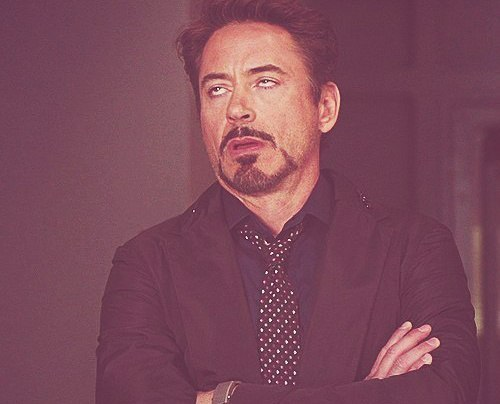

Налицо переобучение. Возможно, стоит добавить деревьев или уменьшить их максимальную глубину, подюирая гиперпараметры с кроссвалидацией. 

Но учитывая долгое время работы алгоритма, есть смысл оставить эксперименты с ним на потом, если не найдем ничего эффективнее.

#### Подход с конкатенацией

Попробуем другой подход. Будем не считать расстояния, а просто конкатенировать векторы друг с другом

In [ ]:
def make_concatenated(candidates, query, base):
    '''
    принимает на вход:
    candidates - список индексов из base
    query - запрос (изначальный вектор)
    base - массив для построения индекса
    
    возвращает: попарно сконкатенированные векторы
                из запроса с векторами кандидатов
    '''
    concatenated_vec = []
    vec_1 = query
    for candidate in candidates:
        vec_2 = base[candidate]
        concatenated_vec.append(np.concatenate([vec_1,vec_2]))
    return np.array(concatenated_vec)

In [ ]:
features = []
target = []

for i, candidates in tqdm(enumerate(idxs)):
    vec_1 = train_array[i]
    for candidate in candidates:
        vec_2 = base_array[candidate]
        current_distances = get_distances(vec_1,vec_2)
        if targets_train[i] == base_index[candidate]:
            target.append(1)
        else:
            target.append(0)
        features.append(current_distances)

In [ ]:
features = []
target = []
for vec_1, index_target in tqdm(zip(train_array, targets_train.values)):
    vec_2 = base_array[base_index_inverted[index_target]]
    concatenated_vec = np.concatenate([vec_1,vec_2])
    features.append(concatenated_vec)
    target.append(1)
    vec_3 = base_array[np.random.randint(base_array.shape[0])]
    concatenated_vec = np.concatenate([vec_1,vec_3])
    features.append(concatenated_vec)
    target.append(0)
features = np.array(features)
target = np.array(target)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.2)

##### LogisticRegression

In [ ]:
model = LogisticRegression(
    max_iter=10000, 
    class_weight='balanced'
)
model.fit(x_train,y_train)

In [ ]:
preds = model.predict(x_test)

print(precision_score(y_test,preds))
print(recall_score(y_test,preds))

Даже проверять не стоит

##### CatBoostClassifier

In [ ]:
model = CatBoostClassifier(random_state=42)
model.fit(x_train,y_train)

In [ ]:
preds = model.predict(x_test)

print(precision_score(y_test,preds))
print(recall_score(y_test,preds))

In [ ]:
%%time
result = []
for i, candidates in enumerate(idxs):
    query = train_array[i]
    query_features = make_concatenated(candidates, query)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)
    print(f'\rОбработан {i+1} запрос', end='')
print()

In [ ]:
accuracy_n(targets_train, np.array(result))

Вывод:

классификатор катбуста показывает слабый результат

##### RandomForestClassifier

In [ ]:
%%time
model = RandomForestClassifier(n_estimators = 100, random_state=42, n_jobs=-1)
model.fit(x_train,y_train)

In [ ]:
preds = model.predict(x_test)

print(precision_score(y_test,preds))
print(recall_score(y_test,preds))

In [ ]:
%%time
result = []
for i, candidates in enumerate(idxs):
    query = train_array[i]
    query_features = make_concatenated(candidates, query)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)
    print(f'\rОбработан {i+1} запрос', end='')
print()

In [ ]:
accuracy_n(targets_train, np.array(result))

Смогли отобрать 5 из 10 и увеличили метрику на 1.5 процента. Время работы алгоритма по построению фич и ранжированию составило 12 минут. Максимизировать precision действительно хорошая идея. Попробуем улучшить результат.

Составим пайплайн со скейлером и моделью. Подберем гиперпараметры с помощью GridSearchCV

In [ ]:
***

In [ ]:
features = []
target = []
for vec_1, index_target in tqdm(zip(train_df.values, targets_train.values)):
    vec_2 = base_df.values[base_index_inverted[index_target]]
    concatenated_vec = np.concatenate([vec_1,vec_2])
    features.append(concatenated_vec)
    target.append(1)
    vec_3 = base_df.values[np.random.randint(base_df.values.shape[0])]
    concatenated_vec = np.concatenate([vec_1,vec_3])
    features.append(concatenated_vec)
    target.append(0)
features = np.array(features)
target = np.array(target)

In [ ]:
pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('clf', DummyClassifier())
    ]
)

In [ ]:
pipeline.fit(features, target)

In [ ]:
params = {
    'clf': [RandomForestClassifier(random_state=42)],
#     'clf__max_depth': [30,40,50,100],
    'clf__max_depth': [100],
#     'clf__n_estimators': [50,100,150],
    'clf__n_estimators': [150],
#     'clf__min_samples_leaf': [1,2,3],
    'clf__min_samples_leaf': [3]
}

In [ ]:
grid_model = GridSearchCV(
    estimator=pipeline, 
    param_grid=params,
    cv=5,
    scoring='precision',
    n_jobs=5,
    verbose=3
)

In [ ]:
grid_model.fit(features, target)

In [ ]:
pd.concat(
    [pd.DataFrame(grid_model.cv_results_['params']),
     pd.Series(grid_model.cv_results_['mean_test_score'],name='score'),
     pd.Series(grid_model.cv_results_['std_test_score'],name='std')],
    axis=1
).sort_values('score', ascending=False).head(50)\
# .to_csv('datasets/cv.csv')

In [ ]:
def make_concatenated(candidates, query, base):
    '''
    принимает на вход:
    candidates - список индексов из base
    query - запрос (изначальный вектор)
    base - массив для построения индекса
    
    возвращает: попарно сконкатенированные векторы
                из запроса с векторами кандидатов
    '''
    concatenated_vec = []
    vec_1 = query
    for candidate in candidates:
        vec_2 = base[candidate]
        concatenated_vec.append(np.concatenate([vec_1,vec_2]))
    return np.array(concatenated_vec)

In [ ]:
pd.read_csv('datasets/cv.csv', index_col=0)

In [ ]:
grid_model.best_params_

In [ ]:
grid_model.best_score_

{'max_depth': 50, 'min_samples_leaf': 3, 'n_estimators': 150}

Глубокие деревья с большим числом эстиматоров менее склонны к переобучению и дают хорошую метрику

In [ ]:
scaler = StandardScaler()
base_array = scaler.fit_transform(base_df)
train_array = scaler.fit_transform(train_df)
validation_array = scaler.transform(validation_df)

In [ ]:
index = faiss.index_factory(dims,'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))
index.nprobe = 16

In [ ]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 5)
accuracy_n(targets_train, idxs)

In [ ]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 20)
accuracy_n(targets_train, idxs)

In [ ]:
base = base_df.values
train = train_df.values
validation = validation_df.values

In [ ]:
%%time
result = []
for i, candidates in enumerate(idxs):
    query = train[i]
    query_features = make_concatenated(candidates, query, base)
    top_5_candidates = candidates[most_similar_5(grid_model.predict_proba(query_features))]
    result.append(top_5_candidates)
    print(f'\rОбработан {i+1} запрос', end='')
print()

In [ ]:
accuracy_n(targets_train, np.array(result))

На 50 соседях время инференса увеличилось, но не критично. Возможно, где-то в алгоритме построения фич кроется неэффективность

Ну и для валидации

In [ ]:
%%time
distances, idxs = index.search(np.ascontiguousarray(validation_array).astype('float32'), 5)
accuracy_n(targets_val, idxs)

In [ ]:
%%time
distances, idxs = index.search(np.ascontiguousarray(validation_array).astype('float32'), 20)
accuracy_n(targets_val, idxs)

In [ ]:
%%time
result = []
for i, candidates in enumerate(idxs):
    query = validation[i]
    query_features = make_concatenated(candidates, query, base)
    top_5_candidates = candidates[most_similar_5(grid_model.predict_proba(query_features))]
    result.append(top_5_candidates)
    print(f'\rОбработан {i+1} запрос', end='')
print()

In [ ]:
accuracy_n(targets_val, np.array(result))

In [ ]:
scaler = StandardScaler()
base_array = scaler.fit_transform(base_df)
train_array = scaler.fit_transform(train_df)
validation_array = scaler.transform(validation_df)

In [ ]:
index = faiss.index_factory(dims,'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))
index.nprobe = 16

In [ ]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 500)
accuracy_n(targets_train, idxs)

In [ ]:
features = []
target = []
for i, candidates in tqdm(enumerate(idxs)):
    vec_1 = train_array[i]
    vec_2 = base_array[base_index_inverted[targets_train.values[i]]]
    vec_3 = base_array[candidates[-1]]
    match = np.concatenate([vec_1,vec_2])
    not_match = np.concatenate([vec_1,vec_3])
    features.append(match)
    target.append(1)
    features.append(not_match)
    target.append(0)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.2)

In [ ]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 20)
accuracy_n(targets_train, idxs)

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(x_train,y_train)

In [ ]:
preds = model.predict(x_test)

print(precision_score(y_test,preds))
print(recall_score(y_test,preds))

In [ ]:
model = CatBoostClassifier(iterations=2000,
                           depth=5,
                           random_state=42)
model.fit(x_train,y_train)

In [ ]:
preds = model.predict(x_test)

print(precision_score(y_test,preds))
print(recall_score(y_test,preds))

In [ ]:
%%time
result = []
for i, candidates in enumerate(idxs):
    query = train_array[i]
    query_features = make_concatenated(candidates, query, base_array)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)
    print(f'\rОбработан {i+1} запрос', end='')
print()

In [ ]:
accuracy_n(targets_train, np.array(result))

In [ ]:
model = CatBoostClassifier(iterations=2000,
                           depth=10,
                           random_state=42)
model.fit(x_train,y_train)

In [ ]:
preds = model.predict(x_test)

print(precision_score(y_test,preds))
print(recall_score(y_test,preds))

In [ ]:
%%time
result = []
for i, candidates in enumerate(idxs):
    query = train_array[i]
    query_features = make_concatenated(candidates, query, base_array)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)
    print(f'\rОбработан {i+1} запрос', end='')
print()

In [ ]:
features = []
target = []
for i, candidates in tqdm(enumerate(idxs)):
    vec_1 = train_df.values[i]
    vec_2 = base_df.values[base_index_inverted[targets_train.values[i]]]
    vec_3 = base_df.values[candidates[-1]]
    match = np.concatenate([vec_1,vec_2])
    not_match = np.concatenate([vec_1,vec_3])
    features.append(match)
    target.append(1)
    features.append(not_match)
    target.append(0)

In [ ]:
pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('clf', DummyClassifier())
    ]
)

In [ ]:
pipeline.fit(features, target)

In [ ]:
params = {
    'clf': [CatBoostClassifier(random_state=42)],
    'clf__depth': [1,5,10],
#     'clf__max_depth': [100],
    'clf__iterations': [500,1000,1500,2000],
#     'clf__n_estimators': [150],
    'clf__learning_rate': [0.01,0.05,0.5],
#     'clf__min_samples_leaf': [3]
}

In [ ]:
grid_model = GridSearchCV(
    estimator=pipeline, 
    param_grid=params,
    cv=5,
    scoring='precision',
    n_jobs=5,
    verbose=3
)

In [ ]:
grid_model.fit(features, target)

In [ ]:
pd.concat(
    [pd.DataFrame(grid_model.cv_results_['params']),
     pd.Series(grid_model.cv_results_['mean_test_score'],name='score'),
     pd.Series(grid_model.cv_results_['std_test_score'],name='std')],
    axis=1
).sort_values('score', ascending=False).head(50)

In [ ]:
%%time
distances, idxs = index.search(np.ascontiguousarray(validation_array).astype('float32'), 20)
accuracy_n(targets_val, idxs)

In [ ]:
%%time
result = []
for i, candidates in enumerate(idxs):
    query = validation[i]
    query_features = make_concatenated(candidates, query, base)
    top_5_candidates = candidates[most_similar_5(grid_model.predict_proba(query_features))]
    result.append(top_5_candidates)
    print(f'\rОбработан {i+1} запрос', end='')
print()

In [ ]:
accuracy_n(targets_val, idxs)

In [ ]:
%%time
distances, idxs = index.search(np.ascontiguousarray(validation_array).astype('float32'), 5)
accuracy_n(targets_val, idxs)

In [ ]:
%%time
distances, idxs = index.search(np.ascontiguousarray(validation_array).astype('float32'), 10)
accuracy_n(targets_val, idxs)

In [ ]:
%%time
result = []
for i, candidates in enumerate(idxs):
    query = validation_array[i]
    query_features = make_concatenated(candidates, query)
    top_5_candidates = candidates[most_similar_5(model.predict_proba(query_features))]
    result.append(top_5_candidates)
    print(f'\rОбработан {i+1} запрос', end='')
print()

In [ ]:
accuracy_n(targets_val, np.array(result))

Делаем несбалансированную выборку

In [117]:
accuracy_n(targets_train, np.array(result))

70.68

In [ ]:
1

## 

## 

In [ ]:
2